# Clustering Sc-10x data

There are 1581 cells to be analyzed. <br>
Please refer to:
file:///Users/waynewu/4.Github/Clustering-for-scRNAseq/dataset/sc-10x/web_summary.html

n_obs: number of cells <br>
n_vars: number of features

### adata:
n_obs x n_vars (1581 x 33538)
1. use indexing and .X to get data. Ex. adata[:, meta].X
2. matrix.A1: transform to ndarray

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


In [2]:
sc.settings.set_figure_params(dpi=80)

In [3]:
# Read in th data
adata = sc.read_10x_mtx(
    './dataset/sc-10x/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)     

... reading from cache file cache/dataset-sc-10x-filtered_feature_bc_matrix-matrix.h5ad


In [4]:
adata

View of AnnData object with n_obs × n_vars = 1581 × 33538 
    var: 'gene_ids', 'feature_types'

# Preprocessing the data

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


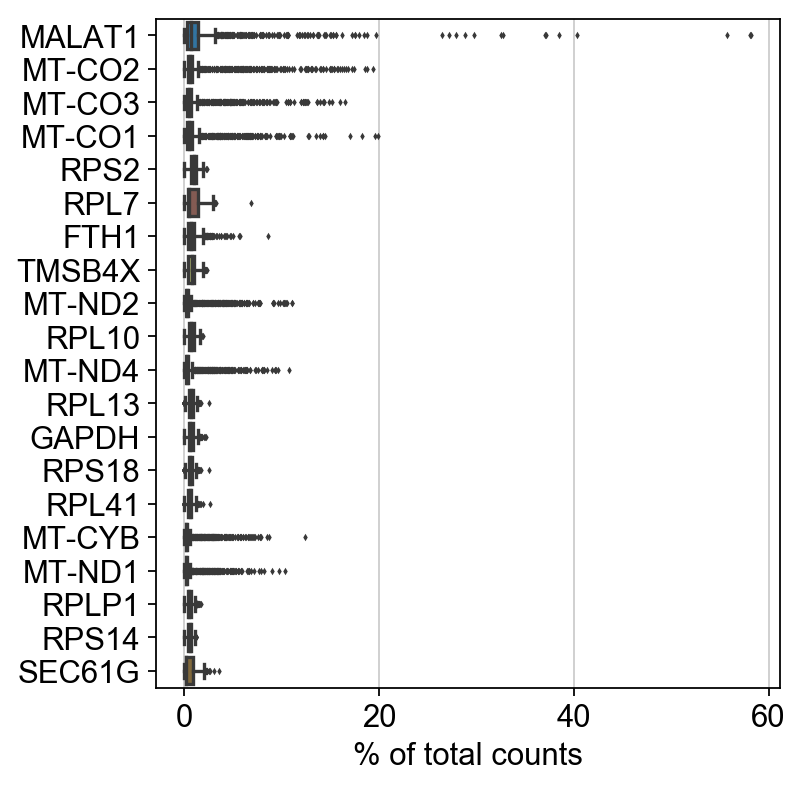

In [5]:
# Show those genes that yield the highest fraction of counts in each single cells, across all cells
sc.pl.highest_expr_genes(adata, n_top=20)

In [6]:
# Filter out cells with less than 200 genes and genes that are detected less than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 3 cells that haveless than 200 genes expressed


Trying to set attribute `.obs` of view, making a copy.


filtered out 15781 genes that are detectedin less than 3 cells


In [7]:
# Quality Measure of mitochondrial genes
# Get the MI percentage of each cell
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

... storing 'feature_types' as categorical


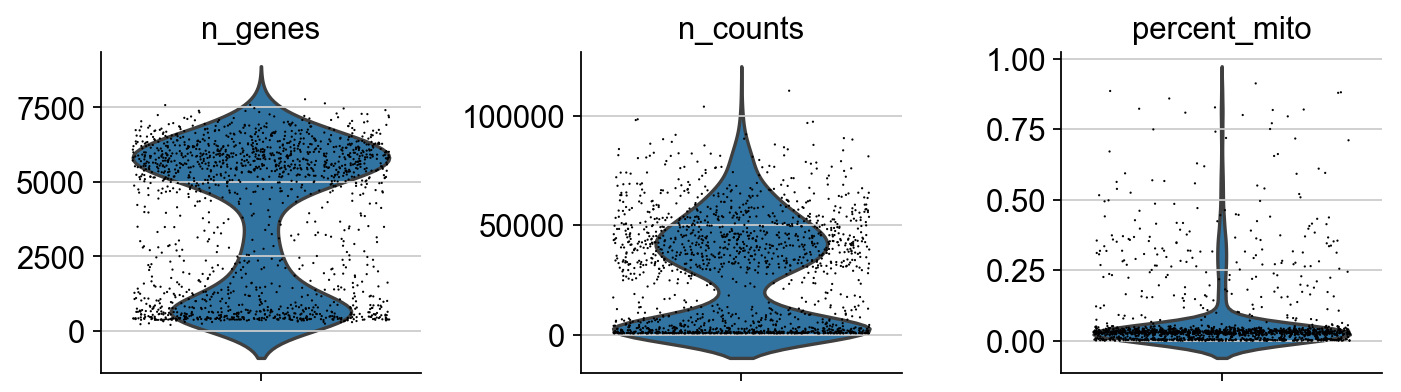

In [8]:
# Computed quality measures
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

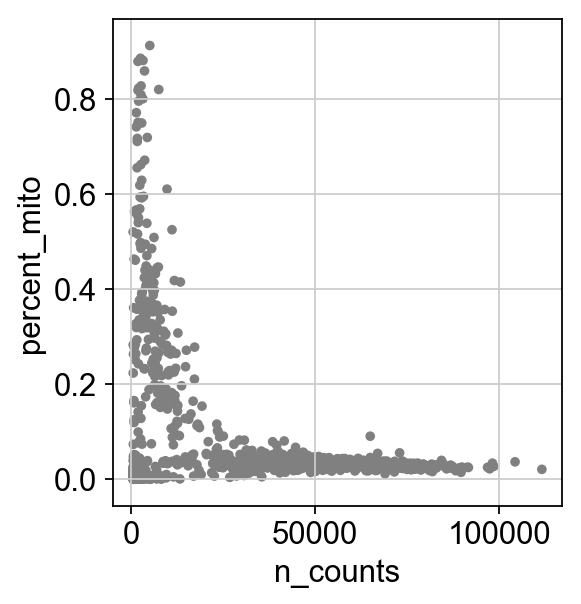

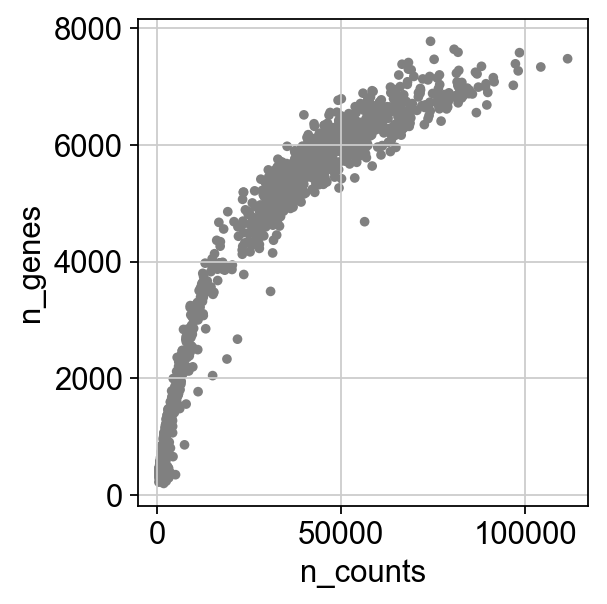

In [9]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [10]:
# Normalize total counts to 10,000 reads per cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# logarithmic the data
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [11]:
adata.raw = adata

# Run PCA and embed the graph

computing PCA with n_comps = 50
    finished (0:00:03)


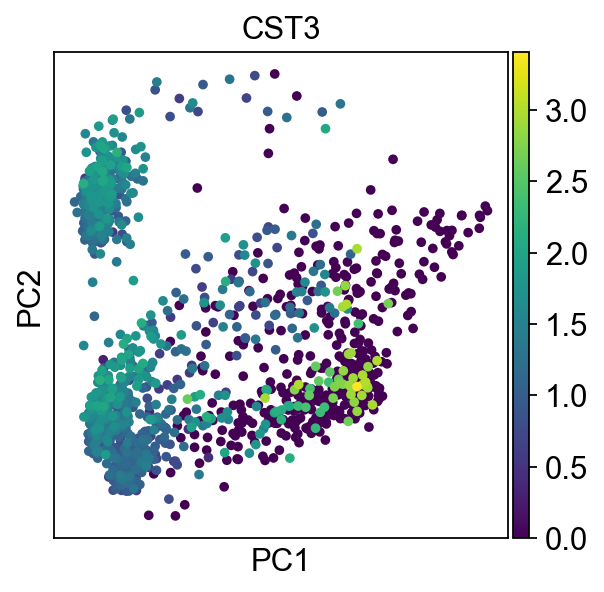

In [12]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')

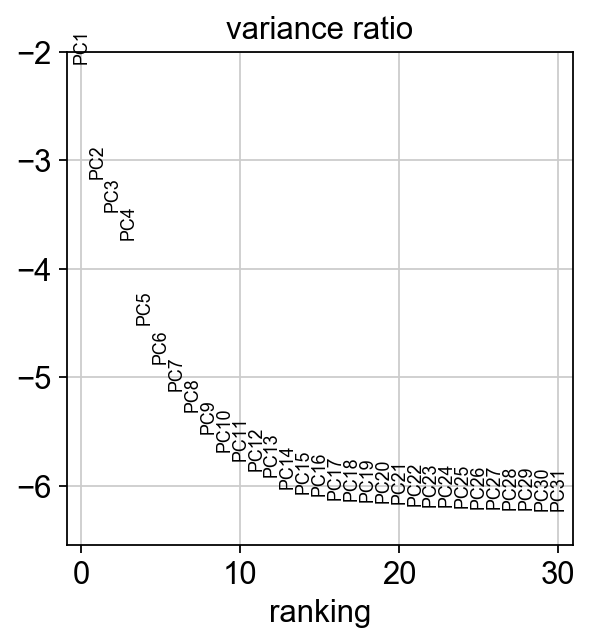

In [13]:
sc.pl.pca_variance_ratio(adata, log=True)

In [14]:
# Calculate the neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
# use UMAP to embed the graph
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


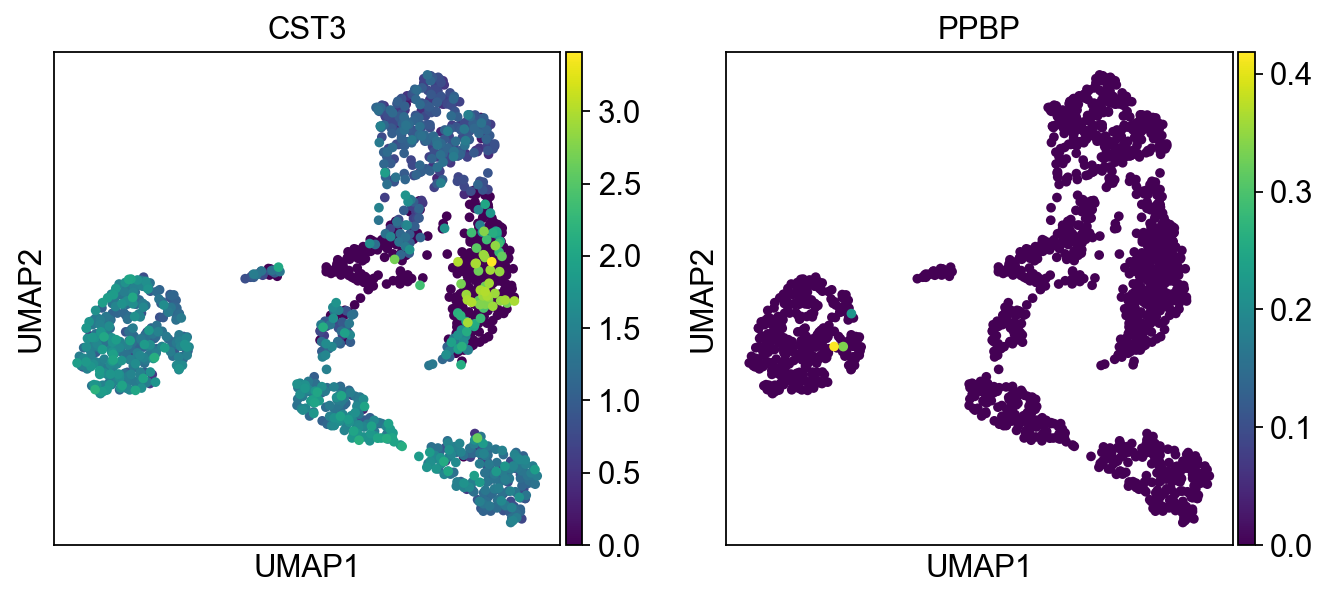

In [15]:
sc.pl.umap(adata, color=['CST3', 'PPBP'])

# Clustering the neighborhood graph

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


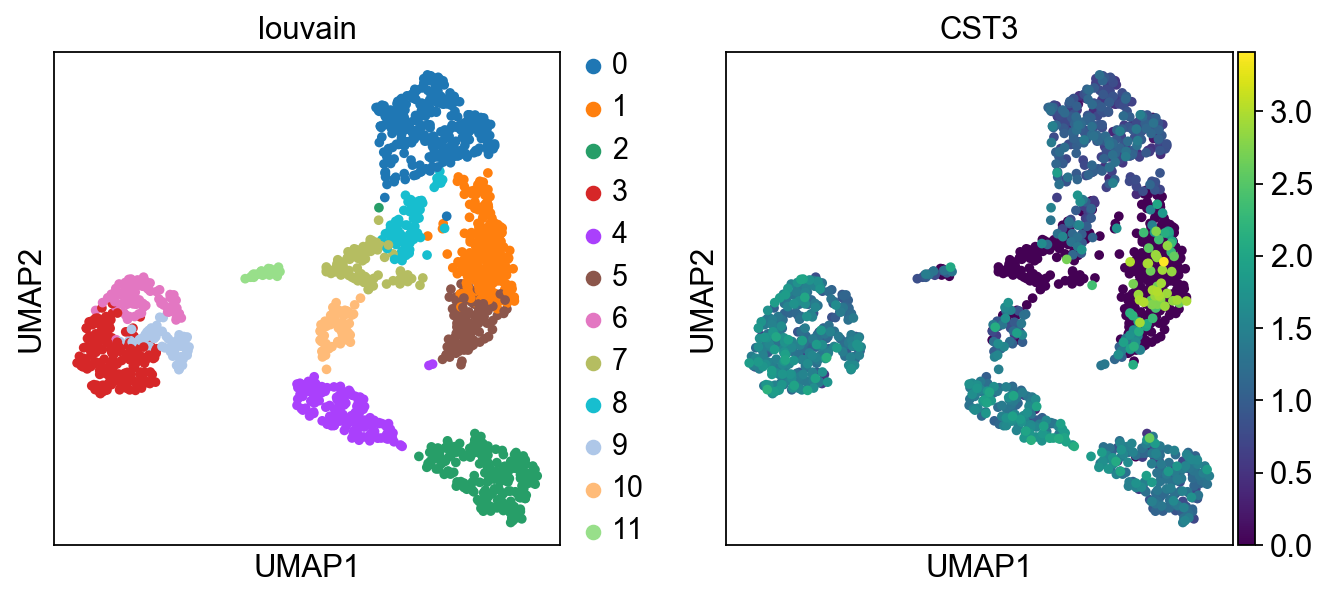

In [17]:
sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain', 'CST3'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


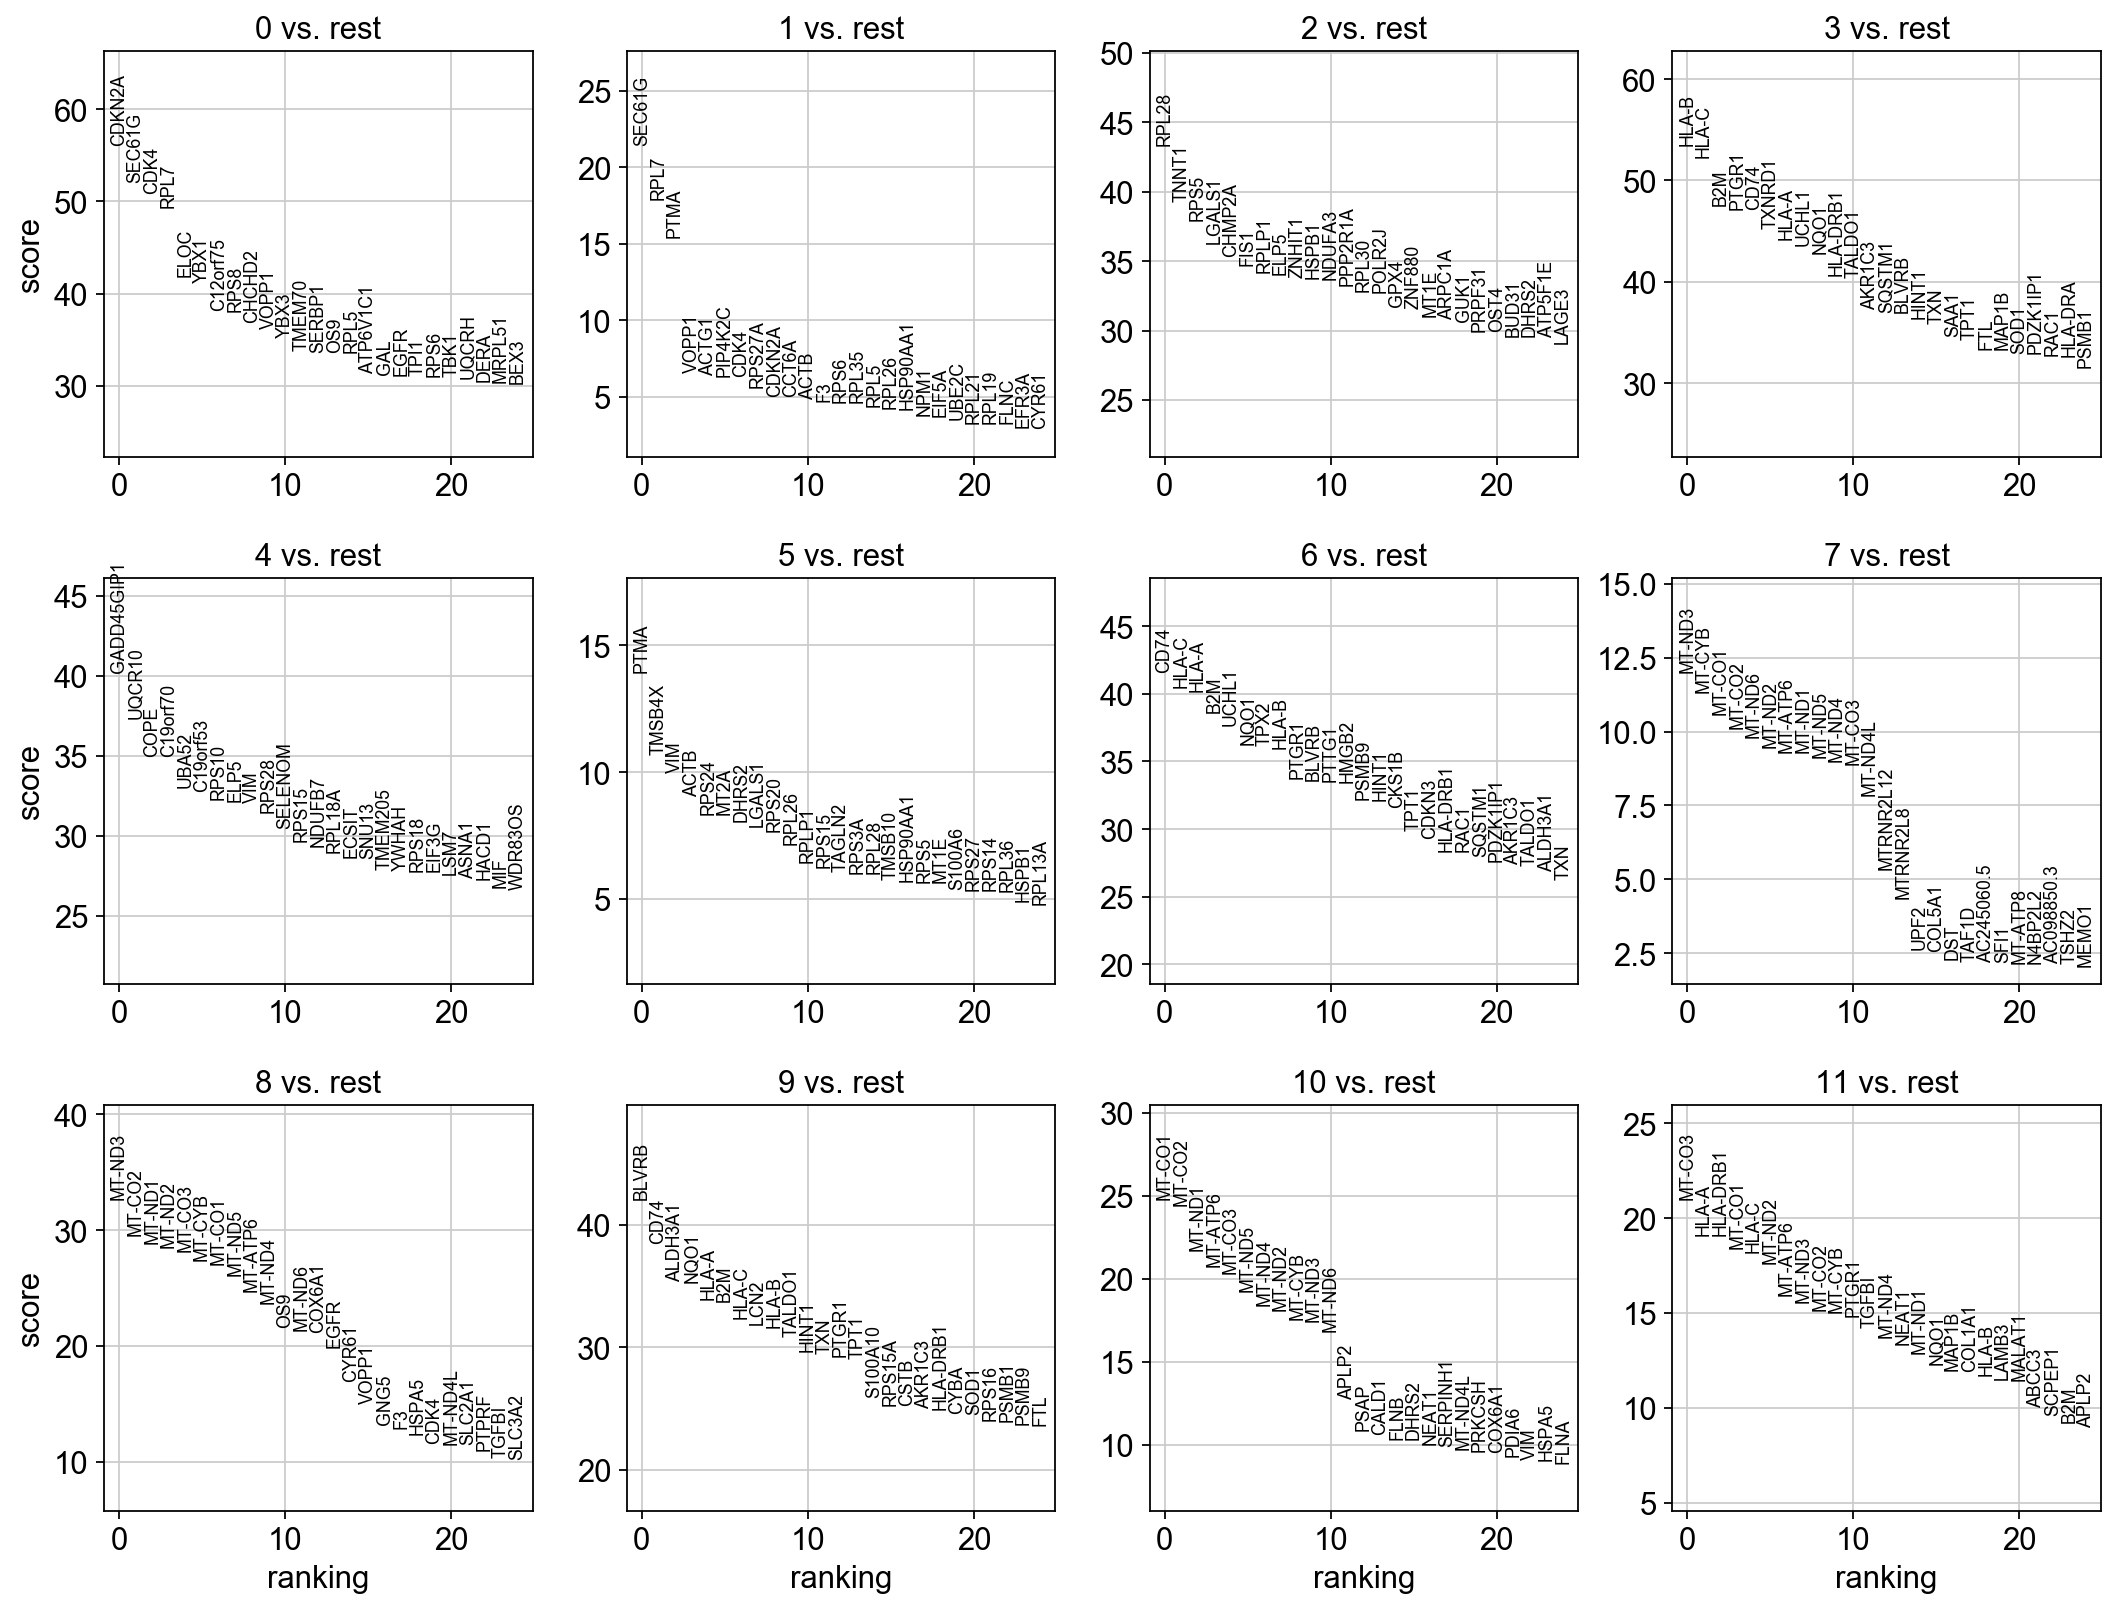

In [18]:
# Find the remarkable genes
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [19]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11
0,CDKN2A,SEC61G,RPL28,HLA-B,GADD45GIP1,PTMA,CD74,MT-ND3,MT-ND3,BLVRB,MT-CO1,MT-CO3
1,SEC61G,RPL7,TNNT1,HLA-C,UQCR10,TMSB4X,HLA-C,MT-CYB,MT-CO2,CD74,MT-CO2,HLA-A
2,CDK4,PTMA,RPS5,B2M,COPE,VIM,HLA-A,MT-CO1,MT-ND1,ALDH3A1,MT-ND1,HLA-DRB1
3,RPL7,VOPP1,LGALS1,PTGR1,C19orf70,ACTB,B2M,MT-CO2,MT-ND2,NQO1,MT-ATP6,MT-CO1
4,ELOC,ACTG1,CHMP2A,CD74,UBA52,RPS24,UCHL1,MT-ND6,MT-CO3,HLA-A,MT-CO3,HLA-C
